## function define

In [1]:
def image_loader(f):
    return skimage.io.imread(f)

In [2]:
def Adaptive_Histogram_Equalization(img):
    return equalize_adapthist(img)

In [3]:
def crop_optic_disk(img,mk, margin = 3):
    img_shape = img.shape
    h = np.where(mk>0)[0]
    h = int(mk.shape[0]/2) if h.size == 0 else h
        
    w = np.where(mk>0)[1]
    w = int(mk.shape[1]/2) if w.size == 0 else w
    
    maxh = min(np.unique(h)[-2]+margin, mk.shape[0])
    minh = max(np.unique(h)[3]-margin, 0)
    maxw = min(np.unique(w)[-2]+margin, mk.shape[1])
    minw = max(np.unique(w)[3]-margin, 0)
    
    img = img[minh:maxh,minw:maxw,:]
    img = resize(img, img_shape)
    return img

In [4]:
def resize_image(img,shape):
    img = resize(img,shape)
    return img

In [5]:
def cleaner(mak, ignore =1):
    idx = []
    tmp = np.pad(mak,3,mode = 'constant', constant_values=0)[:,:,3:6]
    for i in range(tmp.shape[0]-3):
        for j in range(tmp.shape[1]-3):
            if np.sum(tmp[i:i+3,j:j+3,:]> 100) <= ignore*3 :
                idx.append((i,j,3))
    for (i,j,_) in idx:
        tmp[i:i+3,j:j+3,:] = np.zeros((3,3,3))
    return tmp[3:-3,3:-3,:]

In [6]:
def normalize_img(img):
    shape = img.shape
    img = np.float64(img.reshape(-1))
    img -= img.mean()
    img /= img.std()
    img = img.reshape(shape)
#     img = img/ 255
    return img

In [7]:
def random_gamma(img):
    gamma = random.uniform(1.5,1.0)
    gain = random.uniform(1.8,0.5)
    return adjust_gamma(img,gamma, gain)

## import libs

In [1]:
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path
# from train_generator import batch_iterator, random_rotate, random_image_shift
# from utils.util import train_progressbar, slack_message
# from config import TRAIN_FILE, TEST_FILE
import os
import random
import cv2
import polarTransform

from config import *
from iterator import DataGenerator

Using TensorFlow backend.


In [2]:
from utils.image_util import image_loader, resize_image, image_rotate, random_gamma, Adaptive_Histogram_Equalization, random_flip_image, normalize_img, crop_optic_disk, polartransform_image

In [3]:
import skimage
from skimage.exposure import equalize_adapthist, adjust_gamma
from skimage.transform import rescale, resize, downscale_local_mean, rotate

## Generator

In [6]:
gen = DataGenerator(TRAIN_IMAGE, MASK_LOC,2,IMAGE_SHAPE,OPTIC_DISC_SHAPE,is_train=False,copy=False,sample = 90)
# gen = DataGenerator(TEST_IMAGE, MASK_LOC
#                                   ,2,IMAGE_SHAPE, OPTIC_DISC_SHAPE
#                                   ,is_train=True, copy = True, sample=4)

In [ ]:
i=0

In [ ]:
item, y_true = gen[i] #V0217.jpg V0127.jpg
plt.imshow(item[0])
plt.show()
print(y_true[0])
# print(name[0])
plt.imshow(item[1])
plt.show()
print(y_true[1])
# print(name[1])
print(gen.idx)
i+=1

In [ ]:
# item, y_true = gen[0] #V0217.jpg V0127.jpg
plt.imshow(item[0])
plt.show()
print(y_true[0])
# print(name[0])
plt.imshow(item[1])
plt.show()
print(y_true[1])
# print(name[1])
print(gen.idx)

In [8]:
import numpy as np
y_true = np.array([[0.],[0.]])
y_pred = np.array([[0.1],[0.8]])

In [80]:
gen.on_epoch_end()

### unit test

In [202]:
test = 'V0317'
im = os.path.join(TRAIN_IMAGE,'Non-Glaucoma',test+'.jpg')
ma = os.path.join(MASK_LOC,'mask_'+test+'.jpg')
image =image_loader(im)
mask =image_loader(ma)

In [21]:
os.path.join(MASK_LOC,'mask_'+'n0137'+'.jpg')

'D:\\Projects\\my_Glaucoma_project_v2\\dataset\\Glaucoma\\mask_od\\mask_n0137.jpg'

In [203]:
image = resize_image(image,(512, 512, 3))

In [204]:
# plt.imshow(tmp[0])
img = image
img = tmp[0]

In [ ]:
image
mask

In [23]:
mask.shape

(512, 512, 1)

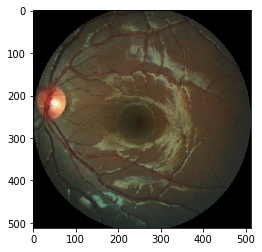

In [24]:
plt.imshow(image)
plt.show()
# plt.imshow(mask)
# plt.show()

In [191]:
angle = random.randint(1,35)*10
img = image_rotate(img, angle)
mask = image_rotate(mask, angle)

In [192]:
img = crop_optic_disk(img,mask,margin=8)

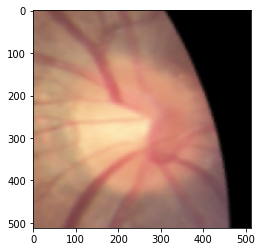

In [193]:
plt.imshow(img)

In [137]:
angle = random.randint(1,35)*10
img = polartransform_image(img,angle)

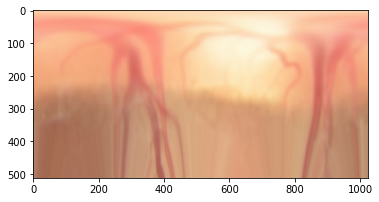

In [138]:
plt.imshow(img)

In [139]:
img = Adaptive_Histogram_Equalization(img,cl=0.03)

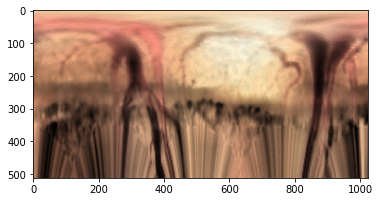

In [140]:
plt.imshow(img)

## segment generator

In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path
import keras 
from seg_iterator import DataGenerator
import cv2
print(cv2.__version__)
from config import *

Using TensorFlow backend.


3.4.2


In [2]:
train_iterator = DataGenerator(TRAIN_IMAGE, MASKING_TRAIN_IMAGE
                               ,1 ,IMAGE_SHAPE, is_train=True,sample = 5)

test_iterator = DataGenerator(TRAIN_IMAGE, MASKING_VAL_IMAGE
                               ,1 ,IMAGE_SHAPE, is_train=False,sample = 5)

 [>>>>>>>>>>>>>>>>>>>>>>>>>_________________________] 5 Done

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


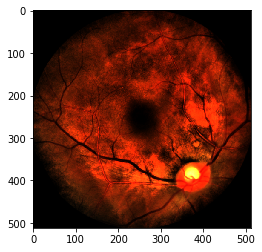

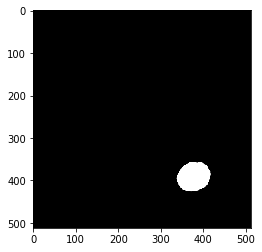

In [15]:
train_images, train_labels = train_iterator[3]
plt.imshow(train_images[0])
plt.show()
plt.imshow(train_labels[0].reshape((512,512)), cmap='gray', vmin=0, vmax=1)
plt.show()

In [ ]:
train_iterator.on_epoch_end()

In [34]:
import collections
collections.Counter(train_labels[0].flatten())

Counter({0.0: 259164, 1.0: 2980})

## cleaning mask data

In [14]:
test = 'V0125'
im = os.path.join(TEST_IMAGE,'Glaucoma',test+'.jpg')
ma = os.path.join(MASK_LOC,'mask_'+test+'.jpg')

In [15]:
img = image_loader(im)
img = resize_image(img,(512,512,3))
mak = image_loader(ma)
# mak = cleaner(mak,1)

In [20]:
img.dtype
equalize_adapthist(img).dtype

dtype('float64')

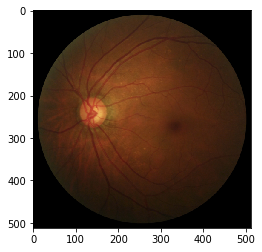

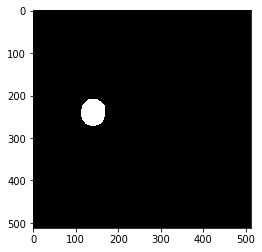

In [16]:
plt.imshow(img)
plt.show()
plt.imshow(mak)
plt.show()

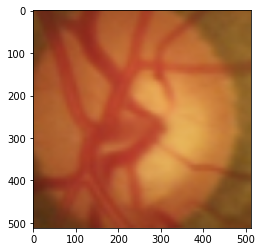

In [89]:
plt.imshow(crop_optic_disk(img,mak,3))

In [569]:
cv2.imwrite(ma,mak)

True